# Predictive Maintenance

## Step 3: Predict the results

### Prerequisites

For this notebook you need to install:

- `pandas`
- `numpy`
- `matplotlib`
- `keras`
- `os`

### What does this file do ?

This file constitues the final step of teh process. It predicts the RUL for the test set, based on the previously trained Neural Network.

### When do I need to run it ?

This file extracts the test data from the `..\input\` folder. It requires a `test.csv` file, that can be created with the `preprocessing.py` file. It also requires a model, found in `output_path` and that can be created with the `trainNN.py` file.

Thus, this script is necessary to predict the results. In case a new test set is available, you need to run first `preprocessing.py` and then this file. It is not required to train the Neural Network (i.e. `trainNN.py` file) if the train set doesn't change.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from keras.models import load_model
import keras.backend as K

Using TensorFlow backend.


In [2]:
# Path from where to retrieve the model output file
output_path = 'model/regression_model_v0.h5'
sequence_length = 50

In [3]:
test_data = pd.read_csv("input/test.csv")

## Evaluate on Test Data

We predict the RUL with the previously trained Neural Network.

### 1. Shape the features

For the same reasons as for the train set, the test set needs to be reshaped.

In [4]:
n_turb = test_data['id'].unique().max()

# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

# We pick the last sequence for each id in the test data
seq_array_test_last = [test_data[test_data['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in range(1, n_turb + 1) if len(test_data[test_data['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)

print("This is the shape of the test set: {} turbines, {} cycles and {} features.".format(
    seq_array_test_last.shape[0], seq_array_test_last.shape[1], seq_array_test_last.shape[2]))

print("There is only {} turbines out of {} as {} turbines didn't have more than {} cycles.".format(
    seq_array_test_last.shape[0], n_turb, n_turb - seq_array_test_last.shape[0], sequence_length))

This is the shape of the test set: 93 turbines, 50 cycles and 25 features.
There is only 93 turbines out of 100 as 7 turbines didn't have more than 50 cycles.


### 2. Selecting and reshaping the labels

Similarly, we pick the labels.

In [5]:
y_mask = [len(test_data[test_data['id']==id]) >= sequence_length for id in test_data['id'].unique()]
label_array_test_last = test_data.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)

### 3. Predicting the RUL for test data

In [6]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

# if best iteration's model was saved then load and use it
if os.path.isfile(output_path):
    estimator = load_model(output_path, custom_objects={'root_mean_squared_error': root_mean_squared_error})

    y_pred_test = estimator.predict(seq_array_test_last)
    y_true_test = label_array_test_last
    
    # test metrics
    scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
    print('\nMSE: {}'.format(scores_test[0]))
    print('\nMSE: {}'.format(scores_test[1]))
    print('\nMAE: {}'.format(scores_test[2]))
    
    s1 = ((y_pred_test - y_true_test)**2).sum()
    moy = y_pred_test.mean()
    s2 = ((y_pred_test - moy)**2).sum()
    s = 1 - s1/s2
    print('\nEfficiency: {}%'.format(s * 100))

    test_set = pd.DataFrame(y_pred_test)
    test_set.to_csv('output/submit_test.csv', index = None)


MSE: 303.4935811360677

MSE: 11.648219652073358

MAE: 11.64821998021936

Efficiency: 85.79311668872833%


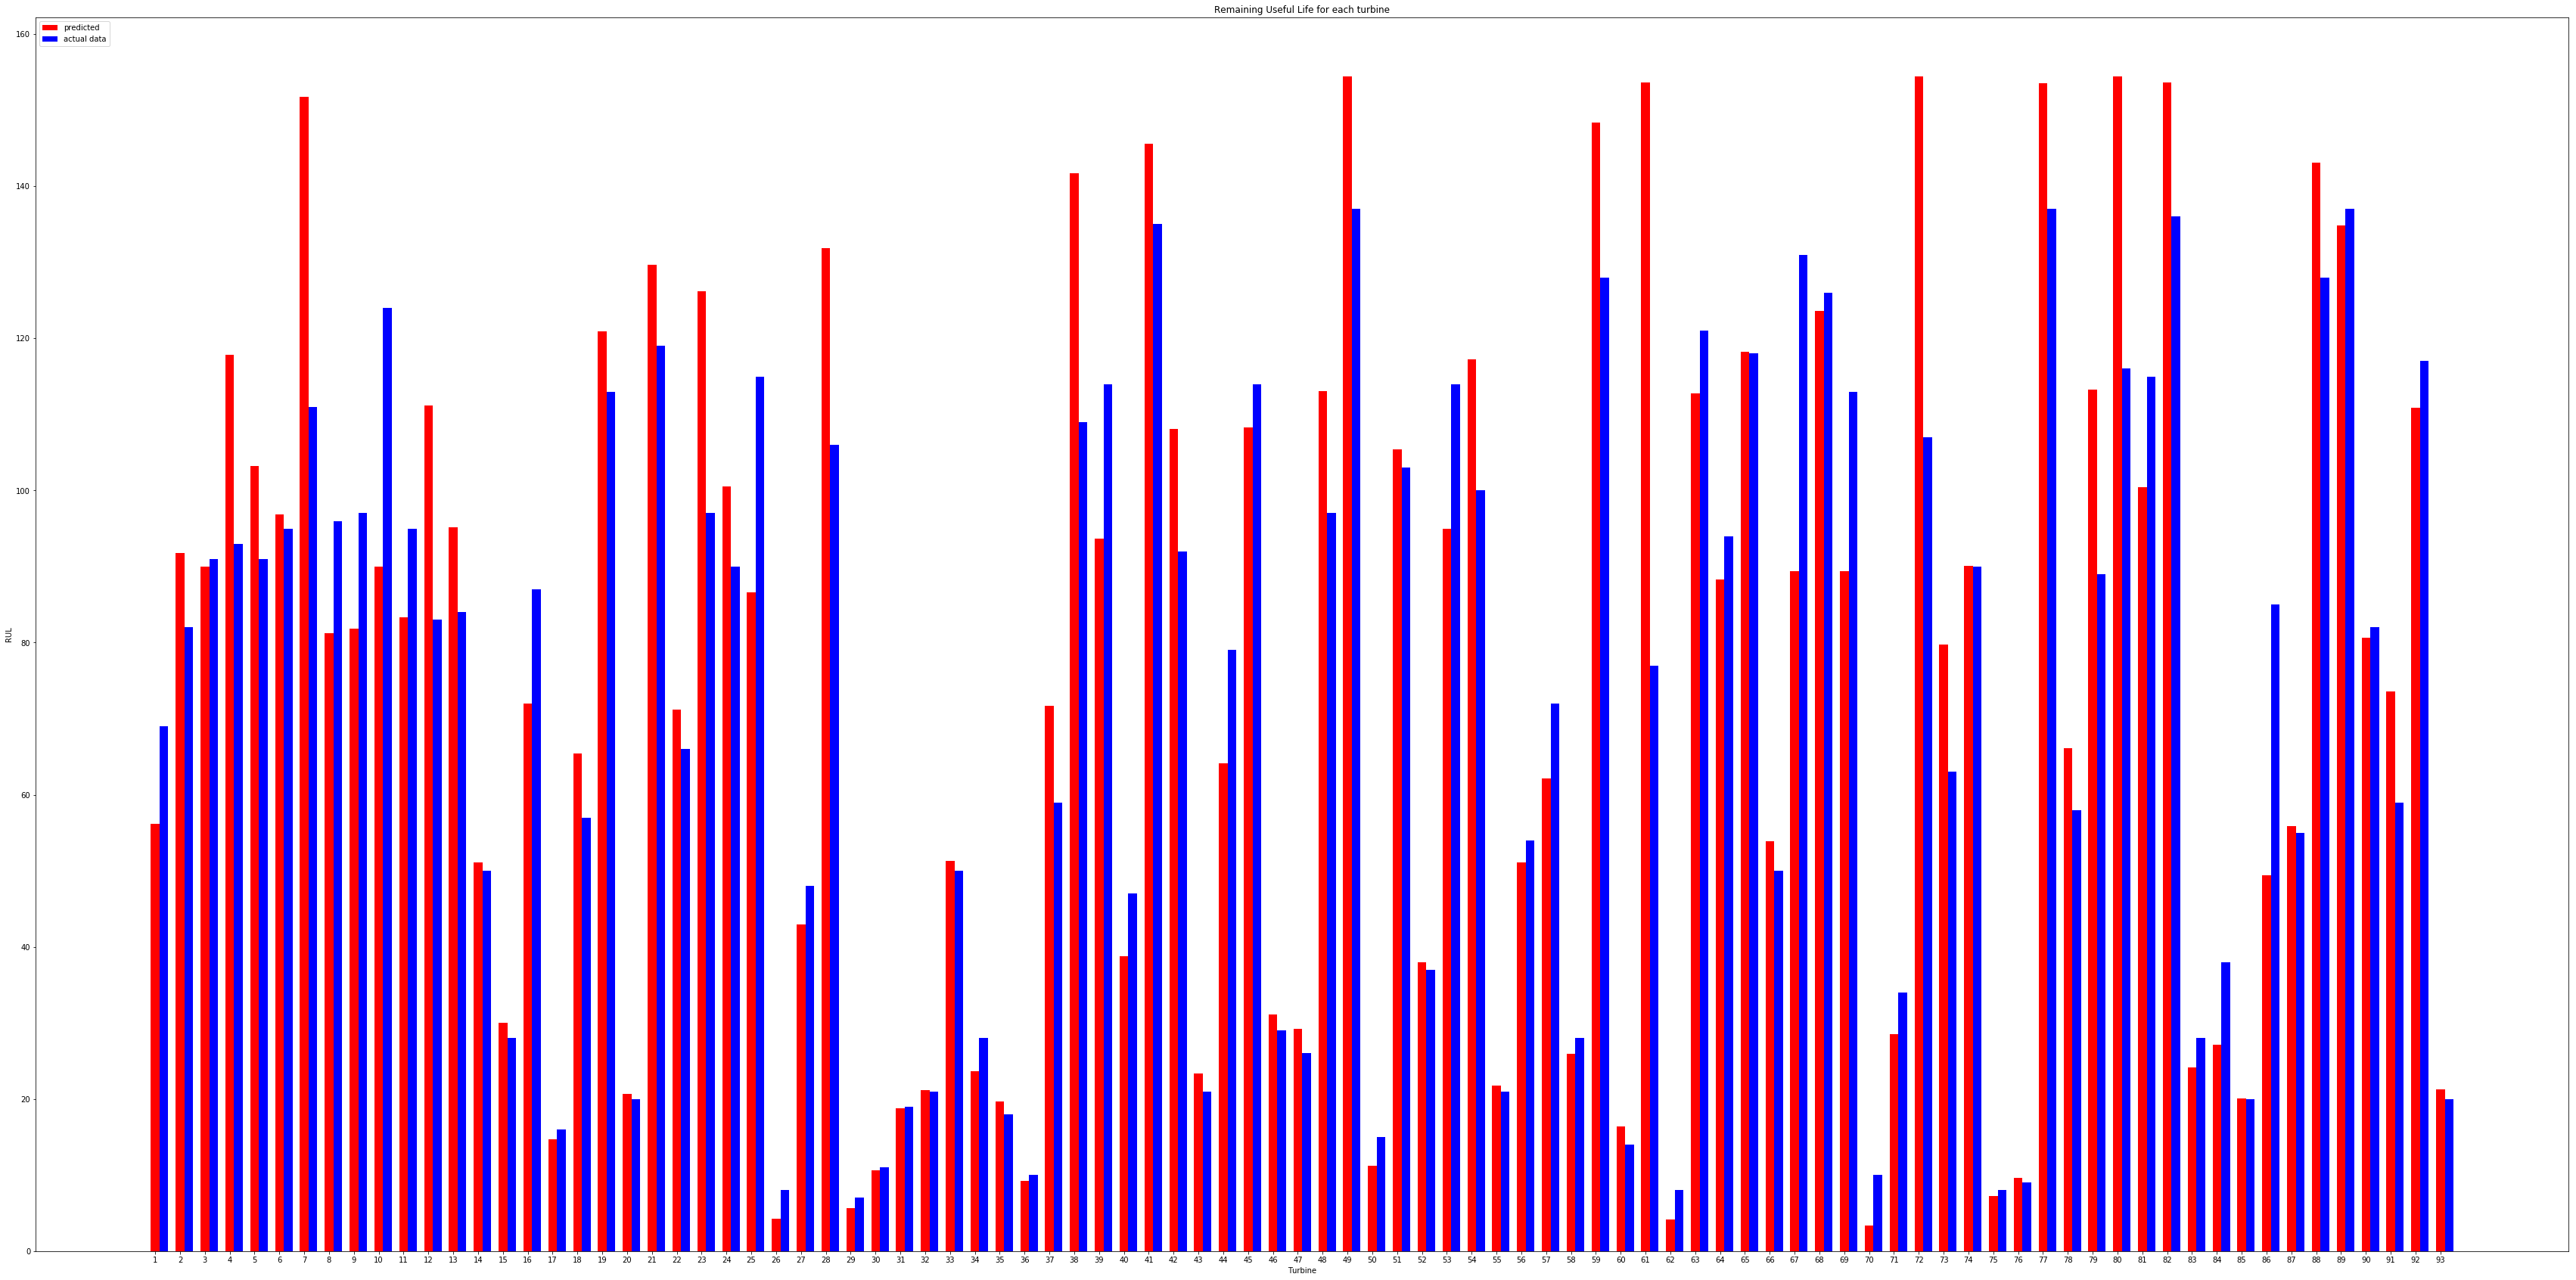

In [8]:
if os.path.isfile(output_path):
    # Plot in blue color the predicted data and in green color the
    # actual data to verify visually the accuracy of the model.
    fig_verify = plt.figure(figsize=(60, 30))
    # plt.plot(y_pred_test, 'ro', color="red", lw=3.0)
    # plt.plot(y_true_test, 'ro', color="blue")
    X = np.arange(1, 94)
    width = 0.35
    plt.bar(X, np.array(y_pred_test).reshape(93,), width, color='r')
    plt.bar(X + width, np.array(y_true_test).reshape(93,), width, color='b')
    plt.xticks(X)
    plt.title('Remaining Useful Life for each turbine')
    plt.ylabel('RUL')
    plt.xlabel('Turbine')
    plt.legend(['predicted', 'actual data'], loc='upper left')
    plt.show()
    fig_verify.savefig("output/model_regression_verify.png")